# Polynomial Regression for Mohs Hardness Modeling

### Why Apache Spark?

Parallel computing is essential for most machine learning tasks. While a GPU isn't necessary for a simple regression task on a relatively small dataset, utilizing all of the machine's cores can significantly reduce training time.

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from pyspark.ml import Pipeline
from pyspark.sql import SparkSession
from pyspark.sql.types import DoubleType
from pyspark.ml.regression import LinearRegression, DecisionTreeRegressor, GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator, Evaluator
from pyspark.ml.feature import RobustScaler, VectorAssembler, VectorIndexer, PolynomialExpansion, StandardScaler
from pyspark.sql.functions import col, mean, lit, udf, collect_list, abs

In [3]:
spark = SparkSession.builder.appName('mohs-hardness').getOrCreate()
spark

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/09/10 00:41:04 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/09/10 00:41:04 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


This dataset was to be scored on the median absolute error (https://www.kaggle.com/competitions/playground-series-s3e25/overview) so let's define a custom class to calculate that to keep track of how we're doing alongside other metrics.

In [4]:
class MedianAbsoluteErrorEvaluator(Evaluator):
    def __init__(self, predictionCol="prediction", labelCol="label"):
        super().__init__()
        self.predictionCol = predictionCol
        self.labelCol = labelCol

    def _evaluate(self, dataset):
        abs_errors = dataset.select(
            abs(col(self.predictionCol) - col(self.labelCol)).alias("abs_error")
        )
        median_abs_error = abs_errors.approxQuantile("abs_error", [0.5], 0.001)[0]
        return median_abs_error

    def isLargerBetter(self):
        return False
    

In [5]:
df = spark.read.csv('train.csv', inferSchema=True, header=True)
df.show(5)

+---+------------------+------------------+--------------------+-------------+--------------------+-----------------+------------------+---------------------+---------------------+------------------+---------------+--------+
| id|allelectrons_Total|     density_Total|allelectrons_Average|val_e_Average|atomicweight_Average|ionenergy_Average|el_neg_chi_Average|R_vdw_element_Average|R_cov_element_Average|   zaratio_Average|density_Average|Hardness|
+---+------------------+------------------+--------------------+-------------+--------------------+-----------------+------------------+---------------------+---------------------+------------------+---------------+--------+
|  0|             100.0|0.8416109999999999|                10.0|          4.8|          20.6125257|          11.0881|             2.766|                1.732|                 0.86|0.4960699999999999|        0.91457|     6.0|
|  1|             100.0|          7.558488|                10.0|          4.8|       20.2988926326| 

In [6]:
train, val = df.randomSplit([0.8, 0.2], seed=42)
train.select(train.columns[1:]).describe().show()

24/09/10 00:41:08 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------+------------------+------------------+--------------------+------------------+--------------------+------------------+------------------+---------------------+---------------------+-------------------+------------------+-----------------+
|summary|allelectrons_Total|     density_Total|allelectrons_Average|     val_e_Average|atomicweight_Average| ionenergy_Average|el_neg_chi_Average|R_vdw_element_Average|R_cov_element_Average|    zaratio_Average|   density_Average|         Hardness|
+-------+------------------+------------------+--------------------+------------------+--------------------+------------------+------------------+---------------------+---------------------+-------------------+------------------+-----------------+
|  count|              8399|              8399|                8399|              8399|                8399|              8399|              8399|                 8399|                 8399|               8399|              8399|             8399|
|   mean

Let's keep a copy in pandas to make EDA easier.

In [7]:
pandas_df = train.toPandas()

### EDA

<Axes: >

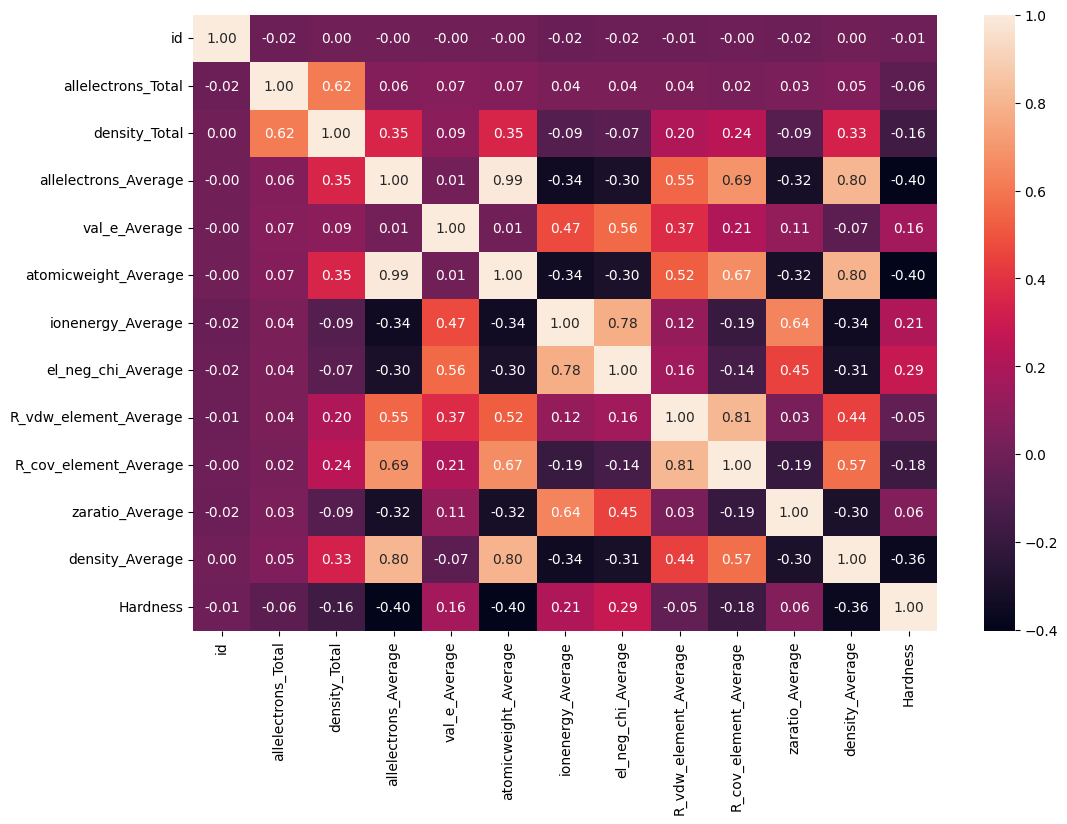

In [8]:
correlaction_matrix = pandas_df.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlaction_matrix, annot=True, fmt="0.2f")

*allelectrons_Average* is highly correlated with *Hardness*. Let's drop it and get rid of some redundancy.

In [9]:
df = df.drop('atomicweight_Average')
pandas_df.drop(columns=['atomicweight_Average'], inplace=True)

The *allelectrons_Total* column suggests the data for it has some outliers, with the max value being 15,300 while the mean is 128 and the standard deviation 224. Visualizing the distributions for each column:

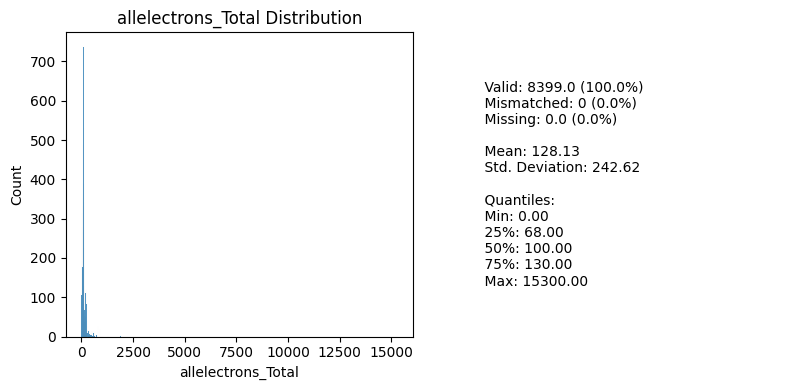

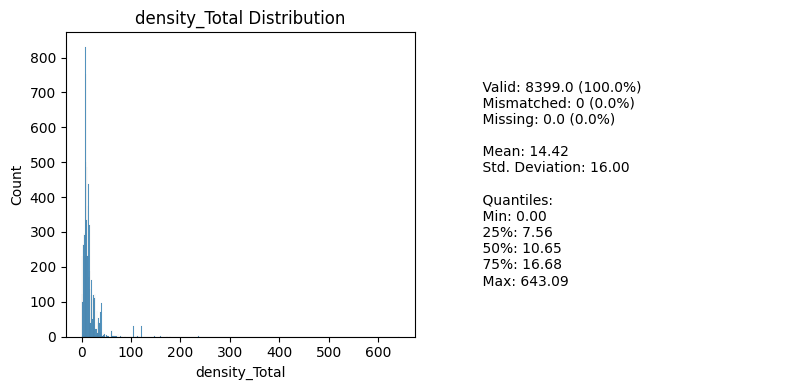

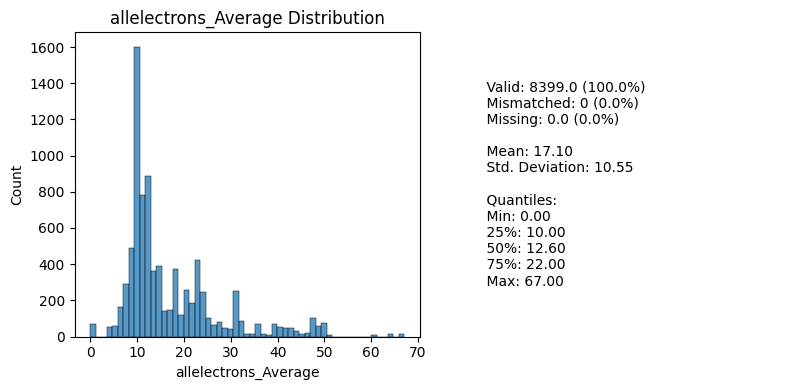

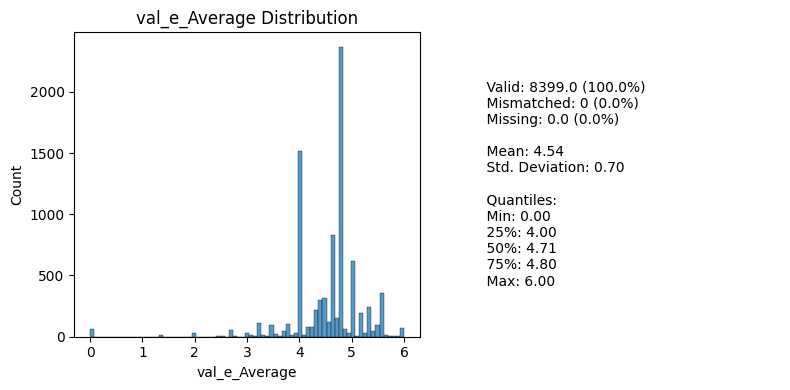

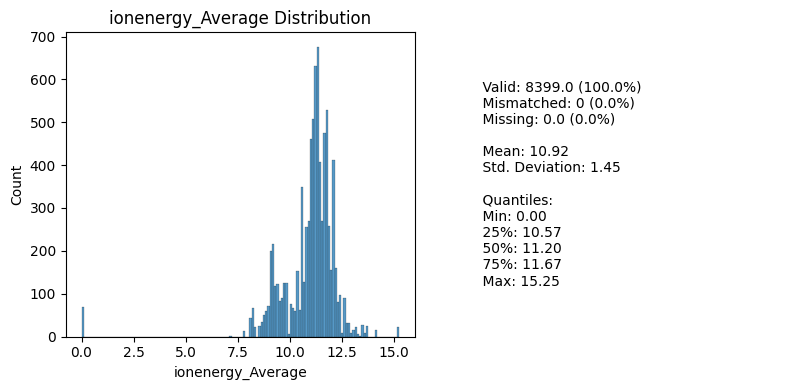

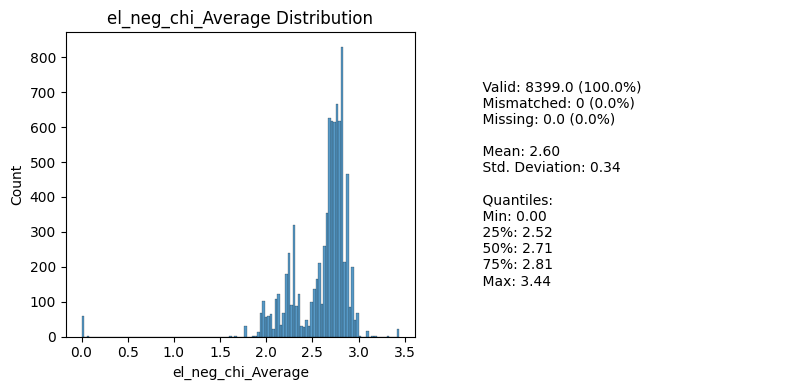

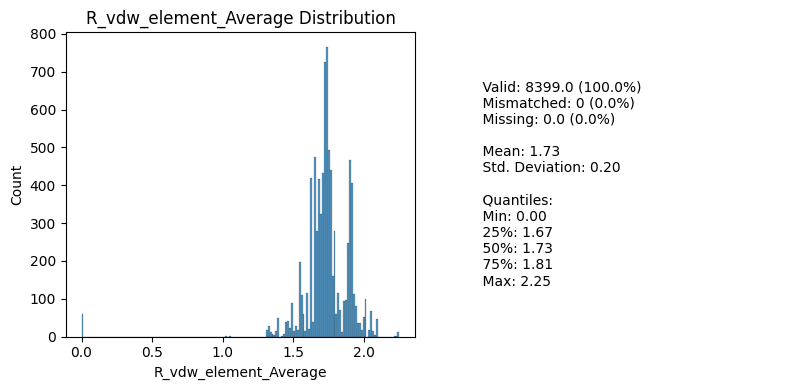

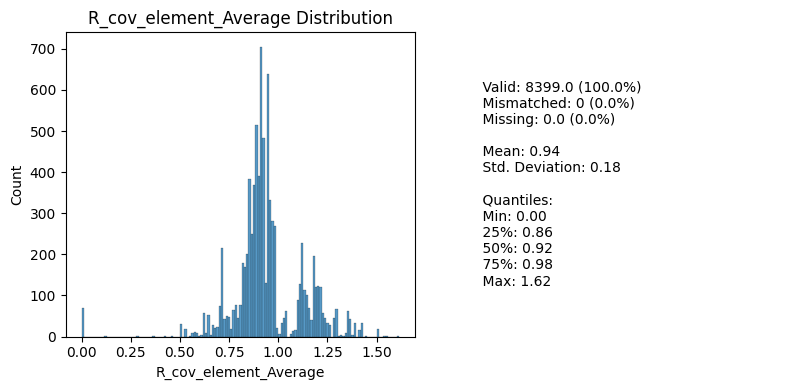

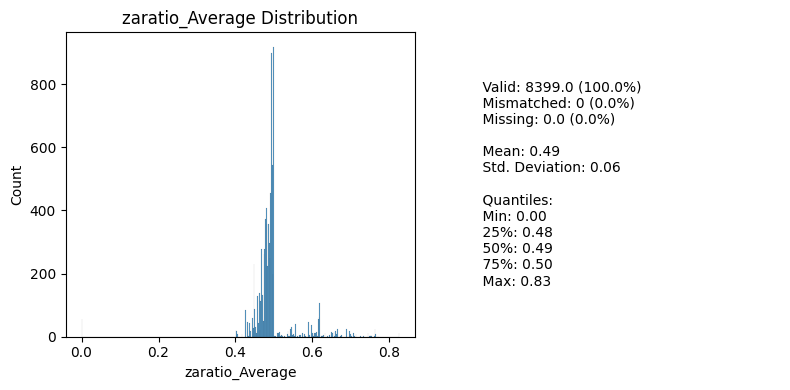

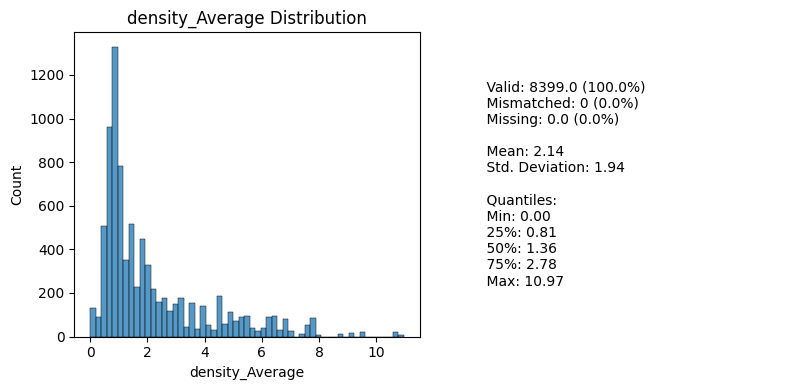

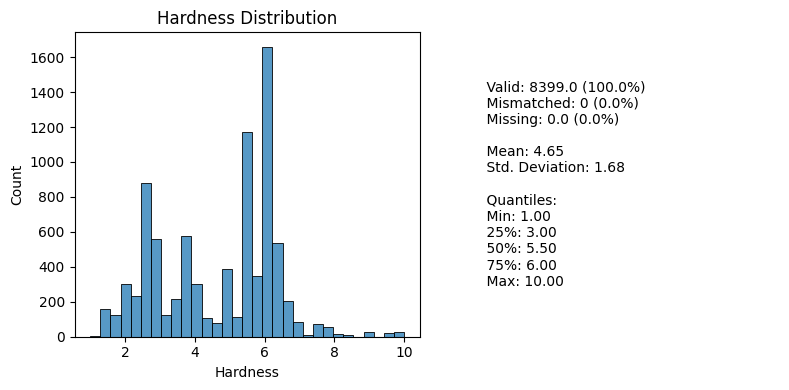

In [10]:
def plot_column_stats(data, column):
    plt.figure(figsize=(8, 4))
    
    # subplot for histogram
    plt.subplot(121)
    sns.histplot(data[column], kde=False)
    plt.title(f'{column} Distribution')
    
    # subplot for stats
    plt.subplot(122)
    stats = data[column].describe()
    valid_count = stats['count']
    total_count = len(data)
    missing_count = total_count - valid_count
    
    stats_text = f"""
    Valid: {valid_count} ({valid_count/total_count:.1%})
    Mismatched: 0 (0.0%)
    Missing: {missing_count} ({missing_count/total_count:.1%})
    
    Mean: {stats['mean']:.2f}
    Std. Deviation: {stats['std']:.2f}
    
    Quantiles:
    Min: {stats['min']:.2f}
    25%: {stats['25%']:.2f}
    50%: {stats['50%']:.2f}
    75%: {stats['75%']:.2f}
    Max: {stats['max']:.2f}
    """
    
    plt.text(0.1, 0.5, stats_text, fontsize=10, verticalalignment='center')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Generate plots for all numeric columns
numeric_columns = pandas_df.select_dtypes(include=['int64', 'float64']).columns

for column in numeric_columns:
    plot_column_stats(pandas_df, column)

Turns out there is just one entry above 10,000 in *all_electrons_Total* (also happens to contain the outlier in *density_Total*) and in a dataset of 10,000 values removing a couple outliers, even if they are not errors in the data, will not severely impact the integrity of it.

Luckily, there is no need to reinvent the wheel as Spark's MLlib has functions to deal with outliers.

In [11]:
train.where('allelectrons_Total > 10000').show()

+----+------------------+-------------+--------------------+-----------------+--------------------+------------------+------------------+---------------------+---------------------+------------------+---------------+--------+
|  id|allelectrons_Total|density_Total|allelectrons_Average|    val_e_Average|atomicweight_Average| ionenergy_Average|el_neg_chi_Average|R_vdw_element_Average|R_cov_element_Average|   zaratio_Average|density_Average|Hardness|
+----+------------------+-------------+--------------------+-----------------+--------------------+------------------+------------------+---------------------+---------------------+------------------+---------------+--------+
|5493|           15300.0|  643.0938035|   8.027397260273974|5.401273885350318|  16.215127021276597|12.976603113207547|3.1792356687898087|    1.567945205479452|   0.7372602739726029|0.5050303184713377|        0.58105|     1.5|
+----+------------------+-------------+--------------------+-----------------+------------------

Now let's check if there exists a linear relationship between the target and any of the features to get a sense for the model we would use.

In [12]:
features = df.columns[1:-1]
features

['allelectrons_Total',
 'density_Total',
 'allelectrons_Average',
 'val_e_Average',
 'ionenergy_Average',
 'el_neg_chi_Average',
 'R_vdw_element_Average',
 'R_cov_element_Average',
 'zaratio_Average',
 'density_Average']

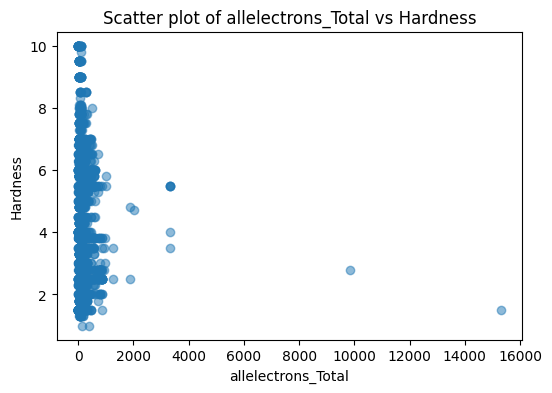

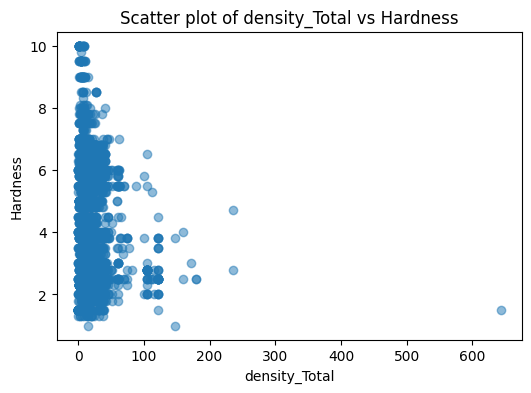

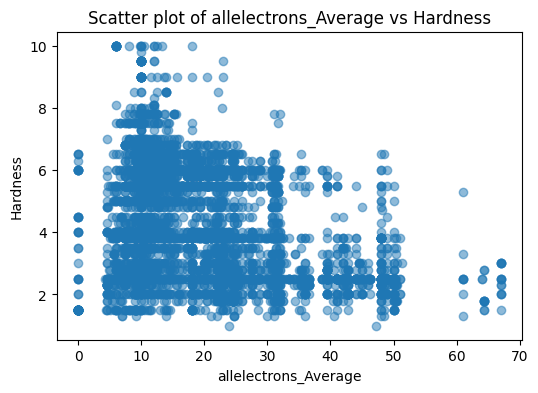

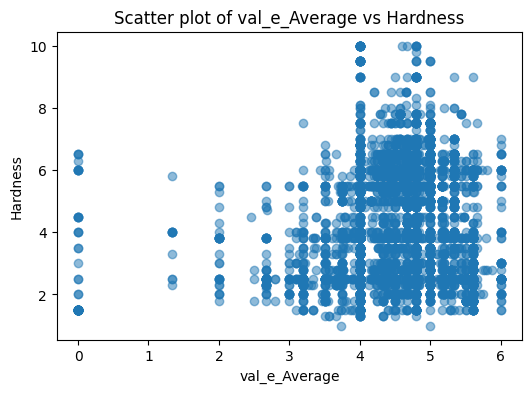

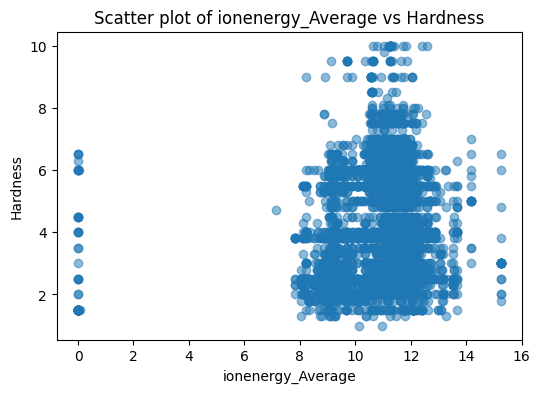

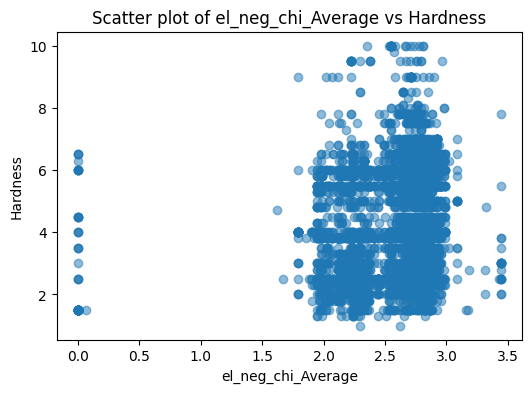

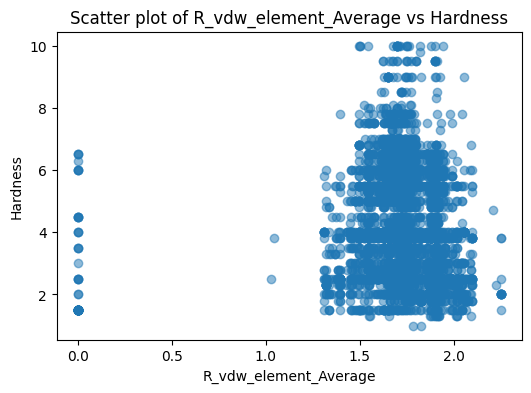

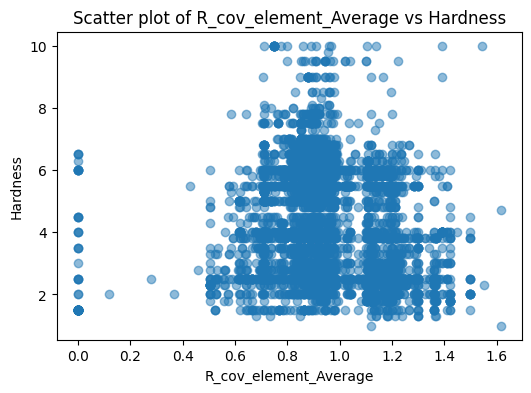

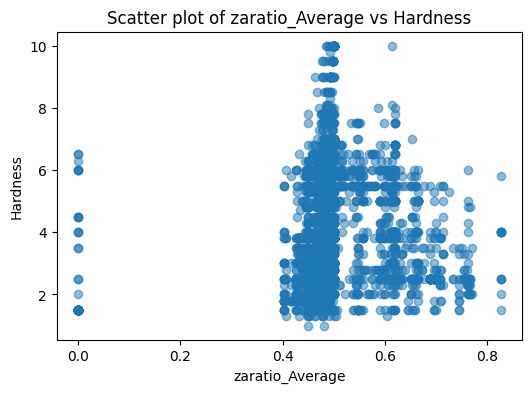

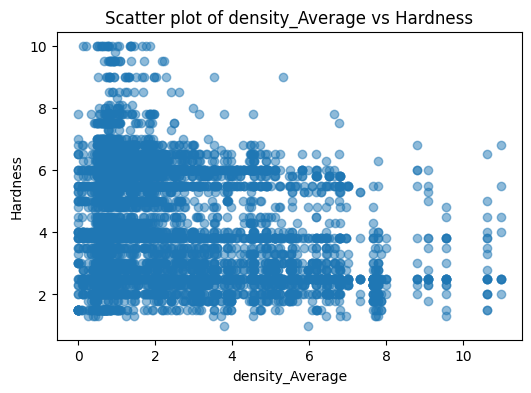

In [13]:
for feature in features:
    plt.figure(figsize=(6, 4))
    plt.scatter(pandas_df[feature], pandas_df['Hardness'], alpha=0.5)
    plt.title(f'Scatter plot of {feature} vs Hardness')
    plt.xlabel(feature)
    plt.ylabel('Hardness')
    plt.show()

Safe to say a simple linear model wouldn't capture the relationship in our data. Let's go for a polynomial model but first we need to remove our outliers.

In [14]:
def scale_df(_df, features):
    assembler = VectorAssembler(inputCols=features, outputCol="features")

    scaler = RobustScaler(inputCol="features", outputCol="scaledFeatures", withScaling=True, withCentering=False, lower=0.25, upper=0.75)
    pipeline = Pipeline(stages=[assembler, scaler])
    scaled_model = pipeline.fit(_df)
    scaled_data = scaled_model.transform(_df)
    return scaled_data

scaled_train = scale_df(train, features)
scaled_val = scale_df(val, features)
scaled_train.select(scaled_train.columns[-2:]).show(5)

+--------------------+--------------------+
|            features|      scaledFeatures|
+--------------------+--------------------+
|[100.0,0.84161099...|[1.61290322580645...|
|[100.0,7.558488,1...|[1.61290322580645...|
|[100.0,8.795296,1...|[1.61290322580645...|
|[116.0,9.577996,1...|[1.87096774193548...|
|[131.0,24.529328,...|[2.11290322580645...|
+--------------------+--------------------+
only showing top 5 rows



### Test

### Baseline model

In [15]:
hardness_mean = train.select(mean("Hardness")).first()[0]
pred_mean = udf(lambda x: hardness_mean, DoubleType())
baseline = val.withColumn("prediction", pred_mean(lit(1)))

evaluator = RegressionEvaluator(labelCol="Hardness", predictionCol="prediction")

baseline_rmse = evaluator.evaluate(baseline, {evaluator.metricName: "rmse"})
baseline_mae = evaluator.evaluate(baseline, {evaluator.metricName: "mae"})

print("Baseline Model Performance:")
print(f"RMSE: {baseline_rmse}")
print(f"Mean absolute error: {baseline_mae}")

Baseline Model Performance:
RMSE: 1.6915705825344913
Mean absolute error: 1.4997583703760884


How our model fairs against the baseline:

In [16]:
poly_expansion = PolynomialExpansion(degree=3, inputCol="scaledFeatures", outputCol="polyFeatures")
df_poly = poly_expansion.transform(scaled_train)

poly_expansion_val = PolynomialExpansion(degree=3, inputCol="scaledFeatures", outputCol="polyFeatures")
df_poly_val = poly_expansion.transform(scaled_val)


scaler = StandardScaler(inputCol="polyFeatures", outputCol="scaledPolyFeatures")
scaler_model = scaler.fit(df_poly)
scaled_df_poly = scaler_model.transform(df_poly)

scaler = StandardScaler(inputCol="polyFeatures", outputCol="scaledPolyFeatures")
scaler_model = scaler.fit(df_poly_val)
scaled_df_poly = scaler_model.transform(df_poly_val)


poly_model = LinearRegression(featuresCol='scaledPolyFeatures', labelCol='Hardness')
poly_model = poly_model.fit(scaled_df_poly)

print("Coefficients: %s" % str(poly_model.coefficients))
print("Intercept: %s" % str(poly_model.intercept))

24/09/10 00:41:15 WARN Instrumentation: [a2bcf008] regParam is zero, which might cause numerical instability and overfitting.
24/09/10 00:41:15 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
24/09/10 00:41:15 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS
24/09/10 00:41:15 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK


Coefficients: [-244.18929269263631,3.0220902031058876,-1.24320502293628,-38.84642168930605,-6.283743370809011,2.9113086779527904,31.786497099628942,-1.5500988281953487,1.765878321122844,64.84342261509585,22.005873623753313,-1.096862181748566,-30.590251811493804,-0.02553310227955816,1.7442443839245119,19.399730378751972,-3.3969015739239192,0.6124599209939341,-0.9681067800081533,9.233283362681053,54.28457783142834,2.2257733156281767,-125.77678070344788,-2.9006840788683244,0.13150454892401914,38.72098890436264,-2.6701783120276192,5.624322286676033,5.236748917412901,9.9270373090686,6.101714929368319,-8.318434285674353,5.20749477568715,-5.467266609219489,-10.333929832701186,249.4977423855916,4.36463739941786,-83.11440518390563,-3.3923973144308737,-4.675647331476533,34.52112301772282,-7.972596532699335,-1.4314478491767382,1.0723455217971505,-6.418795168341645,-29.53961409889385,20.74011119497985,-11.242947429416345,0.17796515624487969,-102.22013254544657,-19.354141267188414,4.729502719068889

In [17]:
predictions = poly_model.transform(scaled_df_poly)

evaluator = RegressionEvaluator(labelCol="Hardness", predictionCol="prediction")

rmse = evaluator.evaluate(predictions, {evaluator.metricName: "rmse"})
mae = evaluator.evaluate(predictions, {evaluator.metricName: "mae"})
r2 = evaluator.evaluate(predictions, {evaluator.metricName: "r2"})
median_abs = MedianAbsoluteErrorEvaluator(predictionCol="prediction", labelCol="Hardness")
median_abs_error = median_abs.evaluate(predictions)

print(f"RMSE: {rmse}")
print(f"Mean absolute error: {mae}")
print(f"Median Absolute Error: {median_abs_error}")

RMSE: 1.2086465126220216
Mean absolute error: 0.9039665841755848
Median Absolute Error: 0.6654625691098861


Much better than the baseline, how about a decision tree?

### Decision tree regression

In [18]:
featureIndexer = VectorIndexer(inputCol="scaledFeatures", outputCol="indexedFeatures", maxCategories=35).fit(scaled_train)
dt = DecisionTreeRegressor(featuresCol="indexedFeatures", labelCol="Hardness")
pipeline = Pipeline(stages=[featureIndexer, dt])

model = pipeline.fit(scaled_train)
predictions = model.transform(scaled_val)

rmse = evaluator.evaluate(predictions, {evaluator.metricName: "rmse"})
mae = evaluator.evaluate(predictions, {evaluator.metricName: "mae"})
median_abs_error = median_abs.evaluate(predictions)

print(f"RMSE: {rmse}")
print(f"Mean absolute error: {mae}")
print(f"Median Absolute Error: {median_abs_error}")

RMSE: 1.3747330485036076
Mean absolute error: 1.0321049429514246
Median Absolute Error: 0.813333333333337


Not great. Maybe using an ensemble of decision trees will help.

In [19]:
evaluator = RegressionEvaluator(labelCol="Hardness", predictionCol="prediction")

gbt = GBTRegressor(featuresCol="indexedFeatures", labelCol="Hardness", maxIter=10)
pipeline = Pipeline(stages=[featureIndexer, gbt])
model = pipeline.fit(scaled_train)
predictions = model.transform(scaled_val)

rmse = evaluator.evaluate(predictions, {evaluator.metricName: "rmse"})
mae = evaluator.evaluate(predictions, {evaluator.metricName: "mae"})
median_abs_error = median_abs.evaluate(predictions)

print(f"RMSE: {rmse}")
print(f"Mean absolute error: {mae}")
print(f"Median Absolute Error: {median_abs_error}")

gbtModel = model.stages[1]
print(gbtModel)


RMSE: 1.3346379893429619
Mean absolute error: 1.0008442406807434
Median Absolute Error: 0.7488844040321325
GBTRegressionModel: uid=GBTRegressor_7bc7851fd119, numTrees=10, numFeatures=10


Better than just a single decision tree, however it still does not beat our polynomial model.

In [20]:
test = spark.read.csv('test.csv', inferSchema=True, header=True)
test = test.drop('atomicweight_Average')
test.show(5)

+-----+------------------+-----------------+--------------------+-------------+------------------+------------------+---------------------+---------------------+---------------+---------------+
|   id|allelectrons_Total|    density_Total|allelectrons_Average|val_e_Average| ionenergy_Average|el_neg_chi_Average|R_vdw_element_Average|R_cov_element_Average|zaratio_Average|density_Average|
+-----+------------------+-----------------+--------------------+-------------+------------------+------------------+---------------------+---------------------+---------------+---------------+
|10407|             884.0|           121.42|               35.36|         5.28|          9.370384|             2.298|               1.9072|                  1.2|      0.4618992|        1.79459|
|10408|              90.0|          9.93196|                18.0|          5.6|           12.0863|2.8680000000000003|   1.6520000000000004|   0.8640000000000001|       0.476196|        1.41194|
|10409|             116.0|    

In [21]:
scaled_test = scale_df(test, features)
scaled_test.select(scaled_test.columns[-2:]).show(5)

+--------------------+--------------------+
|            features|      scaledFeatures|
+--------------------+--------------------+
|[884.0,121.42,35....|[14.7333333333333...|
|[90.0,9.93196,18....|[1.5,1.1171002964...|
|[116.0,7.767992,1...|[1.93333333333333...|
|[100.0,9.10799600...|[1.66666666666666...|
|[55.0,4.03,11.0,4...|[0.91666666666666...|
+--------------------+--------------------+
only showing top 5 rows



In [22]:
poly_expansion = PolynomialExpansion(degree=3, inputCol="scaledFeatures", outputCol="polyFeatures")
df_poly = poly_expansion.transform(scaled_test)

scaler = StandardScaler(inputCol="polyFeatures", outputCol="scaledPolyFeatures")
scaler_model = scaler.fit(df_poly)
scaled_df_poly = scaler_model.transform(df_poly)

predictions = poly_model.transform(scaled_df_poly)

In [23]:
predictions.select(predictions.columns[-1:]).show(5)

+------------------+
|        prediction|
+------------------+
| 41.37720682514805|
| 34.31985573008241|
|36.695666049317545|
| 36.15280818114159|
| 35.36837156706429|
+------------------+
only showing top 5 rows



In [24]:
submission_df = predictions.withColumnRenamed("prediction", "Hardness")
submission_df = submission_df.select("id", "Hardness")
submission_df.show(5)

+-----+------------------+
|   id|          Hardness|
+-----+------------------+
|10407| 41.37720682514805|
|10408| 34.31985573008241|
|10409|36.695666049317545|
|10410| 36.15280818114159|
|10411| 35.36837156706429|
+-----+------------------+
only showing top 5 rows



In [25]:
submission_pd = submission_df.toPandas()
submission_pd.to_csv("submission.csv", index=False)

In [26]:
submission_pd

,id,Hardness
0,10407,41.377207
1,10408,34.319856
2,10409,36.695666
3,10410,36.152808
4,10411,35.368372
...,...,...
6934,17341,38.682804
6935,17342,33.832117
6936,17343,34.516516
6937,17344,30.189743


24/09/10 00:41:22 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


Submitting to Kaggle we get a score of 30.5 as compared to the best score of 0.25, we weren't far off:

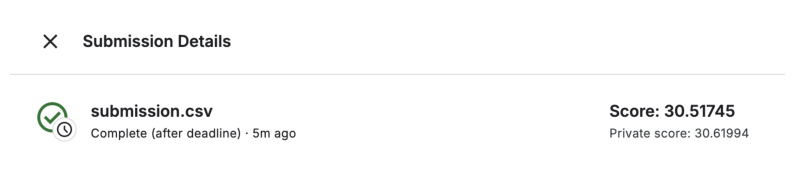

In [37]:
plt.figure(figsize=(10, 6))
img = plt.imread('/Users/aryan/apache-spark/score.png')
plt.imshow(img)
plt.axis('off')
plt.show()

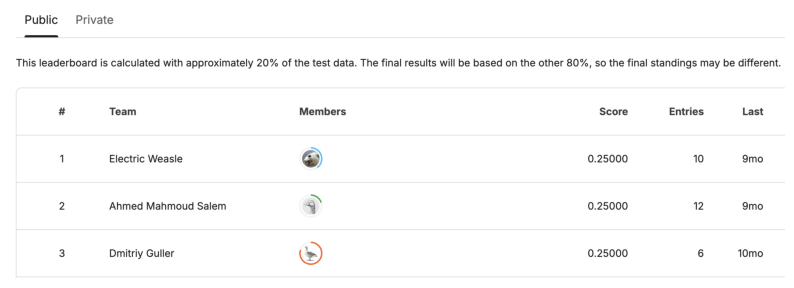

In [38]:
plt.figure(figsize=(10, 6))
img = plt.imread('/Users/aryan/apache-spark/leaderboard.png')
plt.imshow(img)
plt.axis('off')
plt.show()